In [2]:
# ==============================================================================
# 1. SETUP & LIBRARY IMPORT
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Metrics Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Visual Styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Library loaded. Siap menjadi Juri!")

✅ Library loaded. Siap menjadi Juri!


In [5]:
# ==============================================================================
# 2. LOAD DATA UJI (TEST SET) 
# ==============================================================================
DATA_PATH = "../data/" 

try:
    X_test = pd.read_csv(DATA_PATH + "X_test_final.csv")
    y_test = pd.read_csv(DATA_PATH + "y_test_final.csv").values.ravel()
    
    # Load Label Encoder
    le = joblib.load(DATA_PATH + "label_encoder.pkl")
    class_names = le.classes_
    
    print(f"✅ Data Uji siap! ({X_test.shape[0]} baris)")
    
except FileNotFoundError:
    print(f"❌ Error: File tidak ditemukan di {DATA_PATH}")
    print("Cek apakah folder 'data' ada di sebelah folder 'notebooks'?")

✅ Data Uji siap! (5091 baris)


In [7]:
# ==============================================================================
# 3. LOAD SEMUA MODEL - PERBAIKAN PATH
# ==============================================================================
models = {}

# KOREKSI PATH MODEL:
# Kita akses dari: notebooks -> data_modeling -> folder model -> file.pkl
paths = {
    "Random Forest": "data_modeling/random_forest/rf_model_final.pkl",
    "XGBoost":       "data_modeling/xgboost/xgb_model_final.pkl",
    "SVM":           "data_modeling/svm/svm_model_final.pkl",
    "Logistic Reg":  "data_modeling/logistic_regression/logreg_model_final.pkl"
}

# CATATAN: Kalau nama folder di laptopmu beda (misal 'random_forest' tanpa '01'),
# Tolong edit tulisan di atas ya!

print("🔄 Sedang memuat model...")

for name, path in paths.items():
    if os.path.exists(path):
        models[name] = joblib.load(path)
        print(f"  ✅ {name} loaded.")
    else:
        print(f"  ❌ {name} TIDAK DITEMUKAN di: {path}")

print(f"\nTotal Model yang siap diadu: {len(models)}")

🔄 Sedang memuat model...
  ✅ Random Forest loaded.
  ✅ XGBoost loaded.
  ✅ SVM loaded.
  ✅ Logistic Reg loaded.

Total Model yang siap diadu: 4


In [8]:
# ==============================================================================
# 4. KOMPARASI PERFORMA (LOOPING)
# ==============================================================================
results = []

print("🚀 Memulai Evaluasi...")

for name, model in models.items():
    # 1. Prediksi
    y_pred = model.predict(X_test)
    
    # 2. Hitung Metrik
    acc = accuracy_score(y_test, y_pred)
    # Average='weighted' digunakan karena ini Multi-Class Classification
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 3. Simpan ke list
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })
    
    print(f"  -> {name}: Akurasi {acc*100:.2f}%")

# Buat DataFrame dari hasil
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

print("\n🏆 KLASEMEN AKHIR:")
display(df_results)

🚀 Memulai Evaluasi...
  -> Random Forest: Akurasi 99.57%
  -> XGBoost: Akurasi 99.45%
  -> SVM: Akurasi 96.15%
  -> Logistic Reg: Akurasi 90.26%

🏆 KLASEMEN AKHIR:


,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.995679,0.995910,0.995679,0.995752
1,XGBoost,0.994500,0.994776,0.994500,0.994587
2,SVM,0.961501,0.962047,0.961501,0.961687
3,Logistic Reg,0.902573,0.904656,0.902573,0.903032


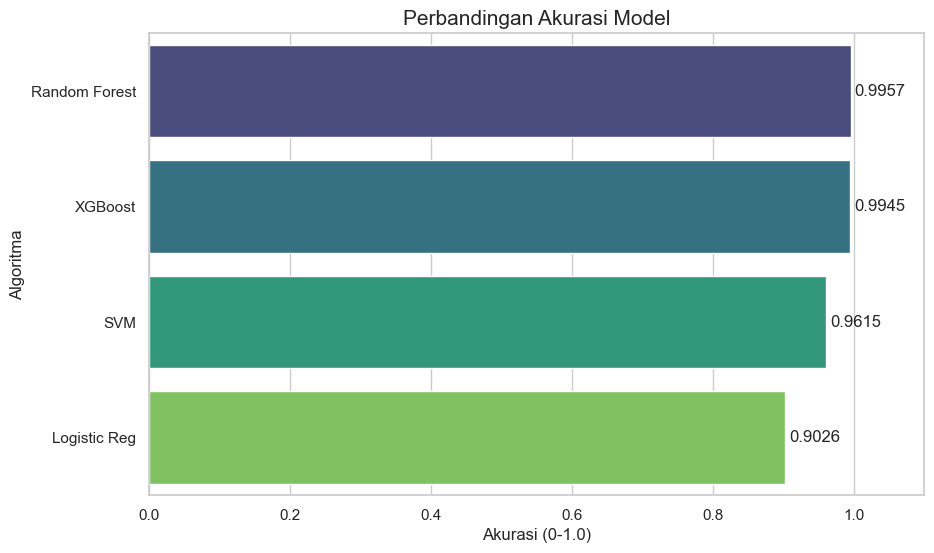

In [9]:
# ==============================================================================
# 5. VISUALISASI PERBANDINGAN MODEL
# ==============================================================================
plt.figure(figsize=(10, 6))

# Plot Bar Chart
ax = sns.barplot(x="Accuracy", y="Model", data=df_results, palette="viridis", hue="Model", legend=False)

# Tulis angka di ujung batang
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=3)

plt.xlim(0, 1.1) # Batas x dari 0 sampai 1.1 biar teks gak kepotong
plt.title("Perbandingan Akurasi Model", fontsize=15)
plt.xlabel("Akurasi (0-1.0)")
plt.ylabel("Algoritma")
plt.show()

In [10]:
# ==============================================================================
# 6. SAFETY CHECK: KEMAMPUAN DETEKSI 'MARGINAL'
# ==============================================================================
print("🔍 Analisis Deteksi Bahaya (Kelas 'Marginal'):\n")

marginal_results = []
marginal_class_index = 3 # Sesuai label encoder: Marginal = 3 (Biasanya)

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Ambil data spesifik Marginal
    # True Positive (Benar Tebak Marginal)
    tp_marginal = cm[marginal_class_index, marginal_class_index]
    # Total Data Marginal Asli
    total_marginal = cm[marginal_class_index, :].sum()
    
    recall_marginal = tp_marginal / total_marginal if total_marginal > 0 else 0
    
    marginal_results.append({
        "Model": name,
        "Recall Marginal": recall_marginal,
        "Terdeteksi": f"{tp_marginal}/{total_marginal}"
    })

df_marginal = pd.DataFrame(marginal_results).sort_values(by="Recall Marginal", ascending=False)
display(df_marginal)

print("\n💡 INTERPRETASI:")
print("Model dengan 'Recall Marginal' tertinggi adalah model yang paling AMAN dipakai.")
print("Karena dia paling sedikit meloloskan air tercemar (False Negative).")

🔍 Analisis Deteksi Bahaya (Kelas 'Marginal'):



,Model,Recall Marginal,Terdeteksi
3,Logistic Reg,1.0000,16/16
2,SVM,0.9375,15/16
1,XGBoost,0.8750,14/16
0,Random Forest,0.8750,14/16



💡 INTERPRETASI:
Model dengan 'Recall Marginal' tertinggi adalah model yang paling AMAN dipakai.
Karena dia paling sedikit meloloskan air tercemar (False Negative).


In [11]:
# ==============================================================================
# 7. KESIMPULAN AKHIR
# ==============================================================================
best_model = df_results.iloc[0]
print("📝 KESIMPULAN OTOMATIS:")
print("="*40)
print(f"1. Model Terbaik secara Akurasi adalah: {best_model['Model'].upper()}")
print(f"   dengan akurasi sebesar {best_model['Accuracy']*100:.2f}%.")

print(f"\n2. Mengapa {best_model['Model']} Menang?")
if best_model['Model'] in ['Random Forest', 'XGBoost']:
    print("   Karena data kualitas air memiliki pola Non-Linear yang kompleks.")
    print("   Metode berbasis Tree (Pohon) lebih jago menangani aturan 'If-Else' patah-patah")
    print("   daripada metode statistik linear atau geometri.")

print("\n3. Rekomendasi:")
print(f"   Untuk implementasi sistem, disarankan menggunakan {best_model['Model']}")
print("   karena memiliki keseimbangan terbaik antara akurasi umum dan deteksi bahaya.")

📝 KESIMPULAN OTOMATIS:
1. Model Terbaik secara Akurasi adalah: RANDOM FOREST
   dengan akurasi sebesar 99.57%.

2. Mengapa Random Forest Menang?
   Karena data kualitas air memiliki pola Non-Linear yang kompleks.
   Metode berbasis Tree (Pohon) lebih jago menangani aturan 'If-Else' patah-patah
   daripada metode statistik linear atau geometri.

3. Rekomendasi:
   Untuk implementasi sistem, disarankan menggunakan Random Forest
   karena memiliki keseimbangan terbaik antara akurasi umum dan deteksi bahaya.
